In [96]:
import requests
import json
import time
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer, HashingVectorizer, TfidfVectorizer
from sklearn.linear_model import Ridge, Lasso, ElasticNet, LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, ExtraTreesClassifier, RandomForestRegressor
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_selection import RFE, SelectKBest, f_regression
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import Pipeline, FeatureUnion
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix, roc_auc_score, auc, roc_curve, recall_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.base import BaseEstimator, TransformerMixin
from imblearn.ensemble import BalancedBaggingClassifier 
import numpy as np
from scipy import stats
import seaborn as sns
import tensorflow as tf
from sklearn import metrics
from datetime import datetime
import xgboost as xgb
import pickle

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

# Spray Effectiveness Analysis

## Get and clean the training data

In [105]:
df = pd.read_csv('train.csv')
weather = pd.read_csv('weather.csv')
spray = pd.read_csv('spray.csv')

In [98]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

In [133]:
def clean_train_data(df):
    
    # map df dataset with weather dataset
    mask3 = np.power((df['Latitude']-41.995),2)+ np.power((df['Longitude']-(-87.933)),2) <= \
            np.power((df['Latitude']-41.786),2)+ np.power((df['Longitude']-(-87.752)),2)
    mask4 = np.power((df['Latitude']-41.995),2)+ np.power((df['Longitude']-(-87.933)),2) > \
            np.power((df['Latitude']-41.786),2)+ np.power((df['Longitude']-(-87.752)),2)
    df.loc[mask3,'weather_station'] = 1
    df.loc[mask4,'weather_station'] = 2
    df_weather = df.join(weather.set_index(['Date','Station']), on=(['Date','weather_station']), how='left')
    
    # map df_weather dataset with spray dataset
    trap_spray = ['T006', 'T009', 'T015', 'T223', 'T014', 'T008', 'T159', 'T089', 'T085', 'T001', 'T228', 'T218',
              'T147', 'T050', 'T142', 'T005', 'T144', 'T013', 'T037', 'T151', 'T153', 'T230', 'T017', 'T044',
              'T162', 'T227', 'T138', 'T066', 'T156', 'T028', 'T231', 'T016', 'T233', 'T143']
    spray_time = ['2011-09-07', '2011-09-07', '2011-09-07', '2011-09-07', '2011-09-07', '2013-07-17', '2013-07-17', 
              '2013-07-17', '2013-07-17', '2013-07-25', '2013-07-25', '2013-07-25', '2013-08-08', '2013-08-08', 
              '2013-08-15', '2013-08-15', '2013-08-15', '2013-08-15', '2013-08-15', '2013-08-15', '2013-08-15', 
              '2013-08-15', '2013-08-16', '2013-08-22', '2013-08-22', '2013-08-22', '2013-08-22', '2013-08-29', 
              '2013-08-29', '2013-08-29', '2013-08-29', '2013-09-05', '2013-09-05', '2013-09-05']
    trap_spray_df = pd.DataFrame([trap_spray,spray_time]).T
    trap_spray_df.columns = ['trap_spray', 'spray_time']
    df_trap = df_weather.join(trap_spray_df.set_index(['trap_spray']), on =(['Trap']), how='left')
    df_trap['spray_time'].fillna('2013-09-26', inplace=True)
    date_format = "%Y-%m-%d"
    date_formated_df = []
    date_formated_spray = []
    delta = []
    sprayed = []
    for i in df_trap['Date']:
        date_formated_df.append(datetime.strptime(i, date_format))
    for i in df_trap['spray_time']:
        date_formated_spray.append(datetime.strptime(i, date_format))
    for i in range(len(date_formated_df)):
        n = (date_formated_df[i] - date_formated_spray[i]).days
        if n > 0:
            delta.append(n)
            sprayed.append(1)
        else:
            delta.append(0)
            sprayed.append(0)
    df_trap['days_after_spray'] = delta
    df_trap['sprayed'] = sprayed
    
    # clean up the total dataset 
    df_total = df_trap
    
    #fix NumMosquitos column
    df_total['NumMosquitos_sum'] = np.nan #create sum column
    #fill sum column with sum of matching rows
    df_total['NumMosquitos_sum'].fillna(df_total.groupby(['Date','Trap','Species'])['NumMosquitos'].transform('sum'), inplace=True)
    df_total.drop(['NumMosquitos'], axis=1, inplace=True) #drop old column
    df_total.drop_duplicates(inplace=True) #drop duplicated rows 
    df_total.reset_index(inplace=True) #reset index 
    
    #create year for time of year
    date_format = "%Y-%m-%d"
    year = []
    for i in df_total['Date']:
        year.append(datetime.strptime(i, date_format).year)
    df_total['year'] = year
    
    #create ordinal date column
    df_total['Date'] = pd.to_datetime(df_total['Date'])
    df_total['ordinal_date'] = df_total['Date'].map(lambda x: x.toordinal())
    
    #create month/day for time of year 
    df_total['month_day'] = df_total['Date'].dt.month + df_total['Date'].map(lambda x: .5 if x.day > 15 else 0)
    
    
    ## drop useless columns
    ## different for train and test dataset because test data doesn't include 'NumMosquitos' column
    ## and test data has "Id" column that need to be dropped
    
    df_total = df_total.drop(['Date','Address','Block','Street','Trap','AddressNumberAndStreet',\
              'AddressAccuracy','weather_station','Depart','CodeSum','Depth',\
              'Water1','SnowFall', 'Sunrise', 'Sunset', 'index','spray_time'],axis=1)
              # NumMosquitos and CodeSum may still helpful (test data doesn't include 'NumMosquitos' column)
              #**changed this to keep NumMosquitos
    
    ## deal with the missing value of the useful columns
    mask5 = (df_total.PrecipTotal == '  T')| (df_total.PrecipTotal =='M')
    mask6 = df_total.WetBulb == 'M'
    mask7 = df_total.StnPressure == 'M'
    df_total.loc[mask5,'PrecipTotal'] = 0.00
    df_total.loc[mask6,'WetBulb'] = round((df_total[df_total.WetBulb!='M']['WetBulb']).astype('int').mean())
    df_total.loc[mask7,'StnPressure'] = round((df_total[df_total.StnPressure!='M']['StnPressure']).astype('float').mean(),2)
    
    ## change the datatype to correct one
    df_total[['Tavg','WetBulb','Heat','Cool']] = df_total[['Tavg','WetBulb','Heat','Cool']].astype(int)
    df_total[['PrecipTotal','StnPressure','SeaLevel','AvgSpeed']] = \
    df_total[['PrecipTotal','StnPressure','SeaLevel','AvgSpeed']].astype(float)
    
    #computer rolling averages 
    for i in [3,5,10,14,21]: #set intervals for rolling average calculation
        for j in ['Tmax', 'Tmin', 'Tavg', 'DewPoint', 'WetBulb', 'Heat', 'Cool',    #columns to compute rolling averages for
                  'PrecipTotal', 'StnPressure', 'SeaLevel','ResultSpeed', 'ResultDir', 'AvgSpeed']:
            df_total[j + str(i)] = df_total[j].rolling(window=i, min_periods=int(i/5)).mean() #create column with interval for each computation
                                                                                #min_periods allows for computing these and not getting NaN values
                                                                                #for reasonable amount of missing data
    ## dummy the object variable
    Species = df_total['Species']
    df_total = pd.get_dummies(df_total,drop_first=True,columns=['Species', 'month_day'])
    
    #fill na's
    df_total.fillna(method='backfill', inplace=True)
    
    
    # return cleaned dataframe

    return df_total, Species

In [135]:
train_clean, Species = clean_train_data(df)
train_clean.shape, Species.shape

((8610, 101), (8610,))

In [102]:
train_clean.year.unique()

array([2007, 2009, 2011, 2013])

## Predict the number of mosquitoes in 2011 and 2013 with no spray
1. Use the same model structure from number of mosquitoes regression model
2. Fit the model using 2007 and 2009 year's data which doesn't spray any insecticide
3. Predict the 2011 and 2013 number of mosquitoes if no spray involved

In [106]:
train_clean_no_spray = train_clean[(train_clean['year'] == 2007) | (train_clean['year'] == 2009)]
train_clean_spray_year = train_clean[(train_clean['year'] == 2011) | (train_clean['year'] == 2013)]

In [107]:
train_clean_no_spray.head()

,Latitude,Longitude,WnvPresent,Tmax,Tmin,Tavg,DewPoint,WetBulb,Heat,Cool,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed,days_after_spray,sprayed,NumMosquitos_sum,year,ordinal_date,Tmax3,Tmin3,Tavg3,DewPoint3,WetBulb3,Heat3,Cool3,PrecipTotal3,StnPressure3,SeaLevel3,ResultSpeed3,ResultDir3,AvgSpeed3,Tmax5,Tmin5,Tavg5,DewPoint5,WetBulb5,Heat5,Cool5,PrecipTotal5,StnPressure5,SeaLevel5,ResultSpeed5,ResultDir5,AvgSpeed5,Tmax10,Tmin10,Tavg10,DewPoint10,WetBulb10,Heat10,Cool10,PrecipTotal10,StnPressure10,SeaLevel10,ResultSpeed10,ResultDir10,AvgSpeed10,Tmax14,Tmin14,Tavg14,DewPoint14,WetBulb14,Heat14,Cool14,PrecipTotal14,StnPressure14,SeaLevel14,ResultSpeed14,ResultDir14,AvgSpeed14,Tmax21,Tmin21,Tavg21,DewPoint21,WetBulb21,Heat21,Cool21,PrecipTotal21,StnPressure21,SeaLevel21,ResultSpeed21,ResultDir21,AvgSpeed21,Species_CULEX PIPIENS,Species_CULEX PIPIENS/RESTUANS,Species_CULEX RESTUANS,Species_CULEX SALINARIUS,Species_CULEX TARSALIS,Species_CULEX TERRITANS,month_day_6.0,month_day_6.5,month_day_7.0,month_day_7.5,month_day_8.0,month_day_8.5,month_day_9.0,month_day_9.5,month_day_10.0
0,41.954690,-87.800991,0,88,60,74,58,65,0,9,0.0,29.39,30.11,5.8,18,6.5,0,0,1.0,2007,732825,88.0,60.0,74.0,58.0,65.0,0.0,9.0,0.0,29.39,30.11,5.8,18.0,6.5,88.0,60.0,74.0,58.0,65.0,0.0,9.0,0.0,29.39,30.11,5.8,18.0,6.5,88.0,60.0,74.0,58.0,65.0,0.0,9.0,0.0,29.39,30.11,5.8,18.0,6.5,88.0,60.0,74.0,58.0,65.0,0.0,9.0,0.0,29.39,30.11,5.8,18.0,6.5,88.0,60.0,74.0,58.0,65.0,0.0,9.0,0.0,29.39,30.11,5.8,18.0,6.5,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,41.954690,-87.800991,0,88,60,74,58,65,0,9,0.0,29.39,30.11,5.8,18,6.5,0,0,1.0,2007,732825,88.0,60.0,74.0,58.0,65.0,0.0,9.0,0.0,29.39,30.11,5.8,18.0,6.5,88.0,60.0,74.0,58.0,65.0,0.0,9.0,0.0,29.39,30.11,5.8,18.0,6.5,88.0,60.0,74.0,58.0,65.0,0.0,9.0,0.0,29.39,30.11,5.8,18.0,6.5,88.0,60.0,74.0,58.0,65.0,0.0,9.0,0.0,29.39,30.11,5.8,18.0,6.5,88.0,60.0,74.0,58.0,65.0,0.0,9.0,0.0,29.39,30.11,5.8,18.0,6.5,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
2,41.994991,-87.769279,0,88,60,74,58,65,0,9,0.0,29.39,30.11,5.8,18,6.5,0,0,1.0,2007,732825,88.0,60.0,74.0,58.0,65.0,0.0,9.0,0.0,29.39,30.11,5.8,18.0,6.5,88.0,60.0,74.0,58.0,65.0,0.0,9.0,0.0,29.39,30.11,5.8,18.0,6.5,88.0,60.0,74.0,58.0,65.0,0.0,9.0,0.0,29.39,30.11,5.8,18.0,6.5,88.0,60.0,74.0,58.0,65.0,0.0,9.0,0.0,29.39,30.11,5.8,18.0,6.5,88.0,60.0,74.0,58.0,65.0,0.0,9.0,0.0,29.39,30.11,5.8,18.0,6.5,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
3,41.974089,-87.824812,0,88,60,74,58,65,0,9,0.0,29.39,30.11,5.8,18,6.5,0,0,1.0,2007,732825,88.0,60.0,74.0,58.0,65.0,0.0,9.0,0.0,29.39,30.11,5.8,18.0,6.5,88.0,60.0,74.0,58.0,65.0,0.0,9.0,0.0,29.39,30.11,5.8,18.0,6.5,88.0,60.0,74.0,58.0,65.0,0.0,9.0,0.0,29.39,30.11,5.8,18.0,6.5,88.0,60.0,74.0,58.0,65.0,0.0,9.0,0.0,29.39,30.11,5.8,18.0,6.5,88.0,60.0,74.0,58.0,65.0,0.0,9.0,0.0,29.39,30.11,5.8,18.0,6.5,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
4,41.974089,-87.824812,0,88,60,74,58,65,0,9,0.0,29.39,30.11,5.8,18,6.5,0,0,4.0,2007,732825,88.0,60.0,74.0,58.0,65.0,0.0,9.0,0.0,29.39,30.11,5.8,18.0,6.5,88.0,60.0,74.0,58.0,65.0,0.0,9.0,0.0,29.39,30.11,5.8,18.0,6.5,88.0,60.0,74.0,58.0,65.0,0.0,9.0,0.0,29.39,30.11,5.8,18.0,6.5,88.0,60.0,74.0,58.0,65.0,0.0,9.0,0.0,29.39,30.11,5.8,18.0,6.5,88.0,60.0,74.0,58.0,65.0,0.0,9.0,0.0,29.39,30.11,5.8,18.0,6.5,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0


In [108]:
#create x and y columns for num mosquitos model training
col_list = ['NumMosquitos_sum', 'WnvPresent']
X_mos_ns = train_clean_no_spray[[cols for cols in train_clean.columns if cols not in col_list]]
y_mos_ns = train_clean_no_spray['NumMosquitos_sum']

#TTS
X_train_mos_ns, X_test_mos_ns, y_train_mos_ns, y_test_mos_ns = train_test_split(X_mos_ns, y_mos_ns, random_state=42, test_size=0.15)


In [81]:
#create x and y columns for num mosquitos model prediction
col_list = ['NumMosquitos_sum', 'WnvPresent']
X_mos_s = train_clean_spray_year[[cols for cols in train_clean.columns if cols not in col_list]]
y_mos_s = train_clean_spray_year['NumMosquitos_sum']

In [110]:
pip_xgb = Pipeline([
    ('ss', StandardScaler()),
    ('xgb', xgb.XGBRegressor())
    
])

params_xgb = {
    'xgb__n_estimators':[40,50,60],
    'xgb__learning_rate': [.15, .20, .30],
    'xgb__max_depth': [3,5,7]
}
gs = GridSearchCV(pip_xgb,param_grid=params_xgb)
gs.fit(X_train_mos_ns,y_train_mos_ns)
print('best cv score', gs.best_score_)
print('best paramas', gs.best_params_)
print('test score', gs.score(X_test_mos_ns, y_test_mos_ns))

best cv score 0.44529190038652045
best paramas {'xgb__learning_rate': 0.2, 'xgb__max_depth': 5, 'xgb__n_estimators': 60}
test score 0.667316863877294


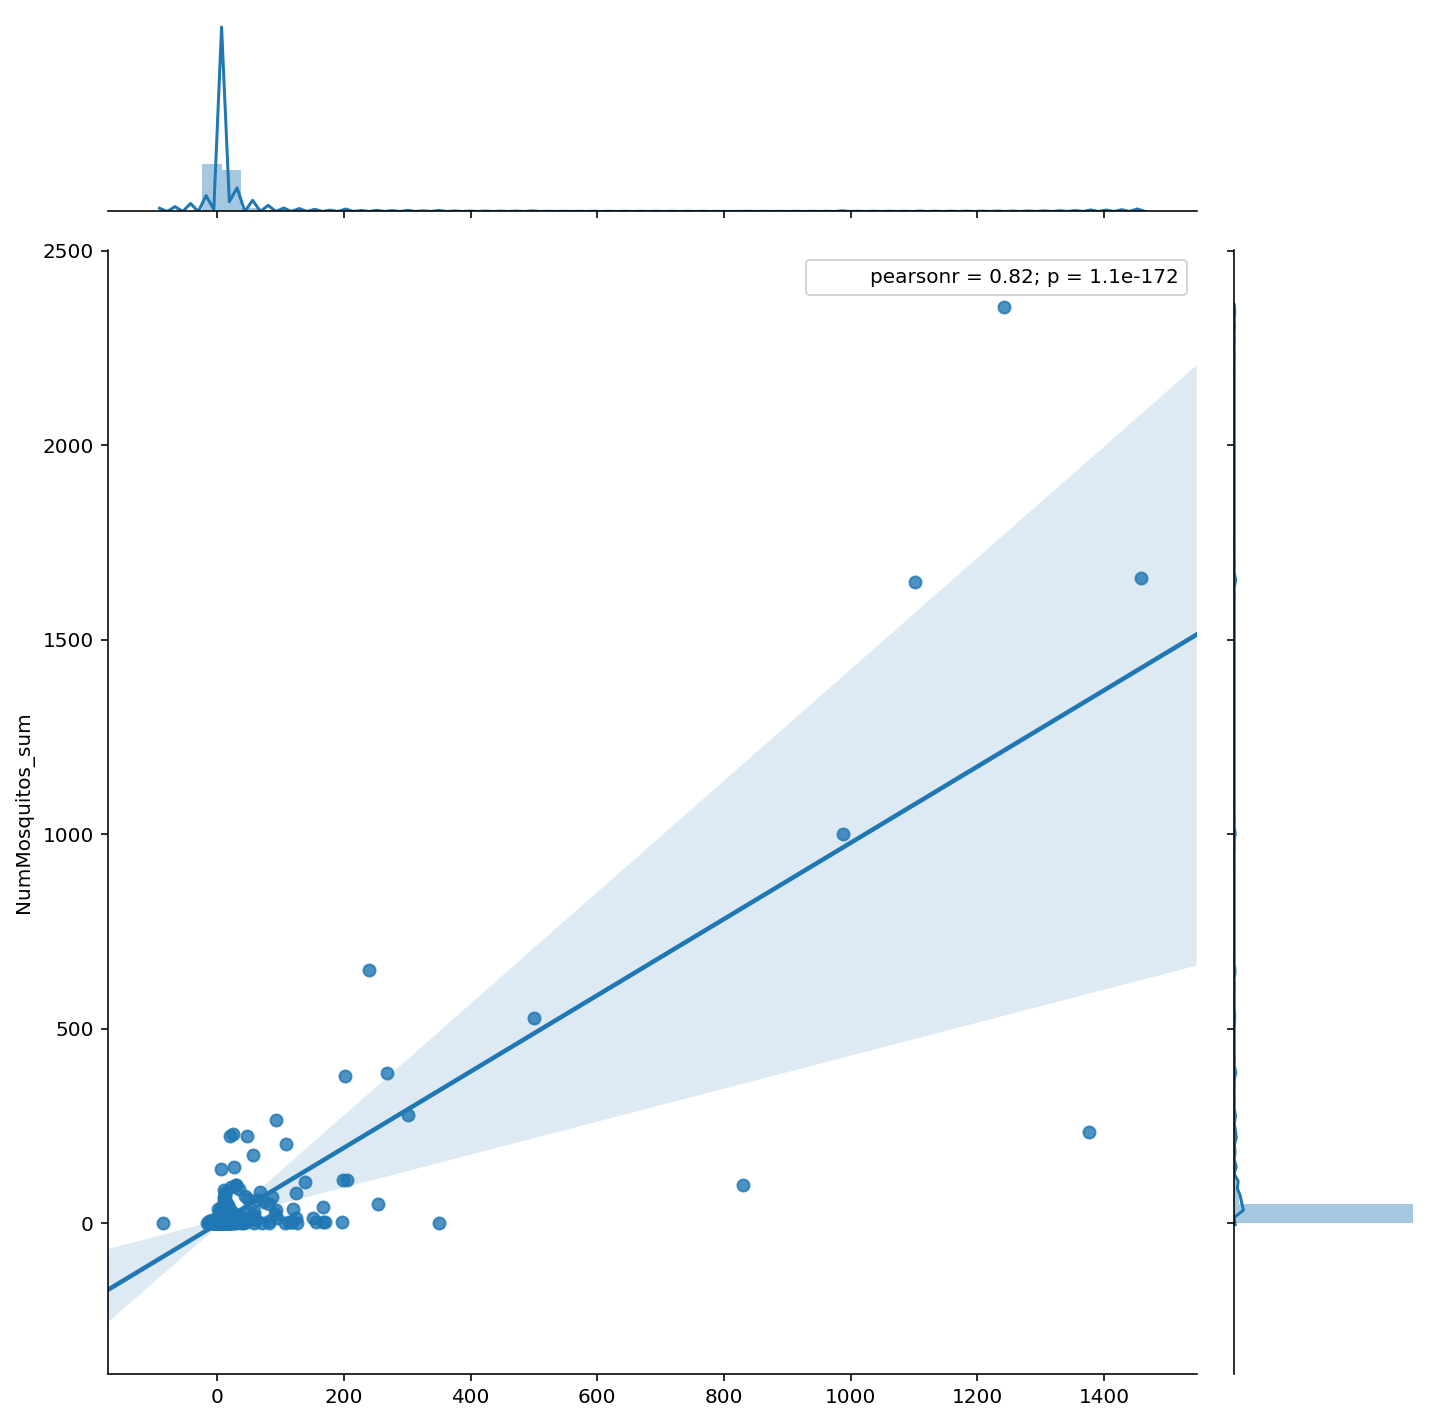

In [111]:
#plot predictions vs actual on test dataset (2011 & 2013)
test_predictions_mos = gs.predict(X_test_mos_ns)
sns.jointplot(test_predictions_mos, y_test_mos_ns, kind='reg', data= train_clean, size=10);

In [112]:
# predict the sprayed year sum of mosquitos
y_mos_predict_ns = gs.predict(X_mos_s)

In [145]:
train_clean_spray_year['NumMosquitos_sum_ns'] = y_mos_predict_ns
train_clean_spray_year['Species'] = Species

In [146]:
train_clean_spray_year.head()

,Latitude,Longitude,WnvPresent,Tmax,Tmin,Tavg,DewPoint,WetBulb,Heat,Cool,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed,days_after_spray,sprayed,NumMosquitos_sum,year,ordinal_date,Tmax3,Tmin3,Tavg3,DewPoint3,WetBulb3,Heat3,Cool3,PrecipTotal3,StnPressure3,SeaLevel3,ResultSpeed3,ResultDir3,AvgSpeed3,Tmax5,Tmin5,Tavg5,DewPoint5,WetBulb5,Heat5,Cool5,PrecipTotal5,StnPressure5,SeaLevel5,ResultSpeed5,ResultDir5,AvgSpeed5,Tmax10,Tmin10,Tavg10,DewPoint10,WetBulb10,Heat10,Cool10,PrecipTotal10,StnPressure10,SeaLevel10,ResultSpeed10,ResultDir10,AvgSpeed10,Tmax14,Tmin14,Tavg14,DewPoint14,WetBulb14,Heat14,Cool14,PrecipTotal14,StnPressure14,SeaLevel14,ResultSpeed14,ResultDir14,AvgSpeed14,Tmax21,Tmin21,Tavg21,DewPoint21,WetBulb21,Heat21,Cool21,PrecipTotal21,StnPressure21,SeaLevel21,ResultSpeed21,ResultDir21,AvgSpeed21,Species_CULEX PIPIENS,Species_CULEX PIPIENS/RESTUANS,Species_CULEX RESTUANS,Species_CULEX SALINARIUS,Species_CULEX TARSALIS,Species_CULEX TERRITANS,month_day_6.0,month_day_6.5,month_day_7.0,month_day_7.5,month_day_8.0,month_day_8.5,month_day_9.0,month_day_9.5,month_day_10.0,NumMosquitos_sum_ns,Species
4758,41.896282,-87.655232,0,71,51,61,56,58,4,0,0.44,29.26,29.92,6.1,1,7.5,0,0,1.0,2011,734298,63.0,46.333333,55.0,49.333333,52.0,10.0,0.0,0.54,29.206667,29.906667,7.9,9.0,8.3,61.4,45.4,53.8,48.0,50.8,11.2,0.0,0.56,29.196,29.904,8.26,10.6,8.46,60.2,44.1,52.5,47.0,49.9,12.5,0.0,0.635,29.178,29.902,8.59,11.8,8.74,59.857143,43.214286,51.785714,46.714286,49.642857,13.214286,0.0,0.707857,29.164286,29.901429,8.735714,12.142857,8.957143,59.571429,43.333333,51.761905,46.476190,49.428571,13.238095,0.0,0.682857,29.167143,29.900952,8.771429,12.428571,8.909524,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,-1.248499,CULEX TERRITANS
4759,41.720848,-87.666014,0,71,51,61,56,58,4,0,0.44,29.26,29.92,6.1,1,7.5,0,0,1.0,2011,734298,67.0,48.666667,58.0,52.666667,55.0,7.0,0.0,0.49,29.233333,29.913333,7.0,5.0,7.9,63.8,46.8,55.6,50.0,52.6,9.4,0.0,0.53,29.212,29.908,7.72,8.2,8.22,61.4,45.1,53.6,48.0,50.8,11.4,0.0,0.590,29.191,29.904,8.29,10.6,8.54,60.714286,43.928571,52.571429,47.428571,50.285714,12.428571,0.0,0.675714,29.173571,29.902857,8.521429,11.285714,8.814286,60.142857,43.666667,52.190476,46.952381,49.857143,12.809524,0.0,0.675714,29.170952,29.901905,8.642857,11.857143,8.852381,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,4.520897,CULEX PIPIENS/RESTUANS
4760,42.017430,-87.687769,0,71,51,61,56,58,4,0,0.44,29.26,29.92,6.1,1,7.5,0,0,2.0,2011,734298,71.0,51.000000,61.0,56.000000,58.0,4.0,0.0,0.44,29.260000,29.920000,6.1,1.0,7.5,66.2,48.2,57.4,52.0,54.4,7.6,0.0,0.50,29.228,29.912,7.18,5.8,7.98,62.6,45.8,54.5,49.0,51.7,10.5,0.0,0.575,29.199,29.906,8.02,9.4,8.42,61.571429,44.642857,53.357143,48.142857,50.928571,11.642857,0.0,0.643571,29.182857,29.904286,8.307143,10.428571,8.671429,60.714286,44.000000,52.619048,47.428571,50.285714,12.380952,0.0,0.668571,29.174762,29.902857,8.514286,11.285714,8.795238,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,960.274902,CULEX RESTUANS
4761,41.986921,-87.689778,0,71,51,61,56,58,4,0,0.44,29.26,29.92,6.1,1,7.5,0,0,1.0,2011,734298,71.0,51.000000,61.0,56.000000,58.0,4.0,0.0,0.44,29.260000,29.920000,6.1,1.0,7.5,68.6,49.6,59.2,54.0,56.2,5.8,0.0,0.47,29.244,29.916,6.64,3.4,7.74,63.8,46.8,55.6,50.0,52.6,9.4,0.0,0.530,29.212,29.908,7.72,8.2,8.22,62.428571,45.357143,54.142857,48.857143,51.571429,10.857143,0.0,0.611429,29.192143,29.905714,8.092857,9.571429,8.528571,61.285714,44.333333,53.047619,47.904762,50.714286,11.952381,0.0,0.661429,29.178571,29.903810,8.385714,10.714286,8.738095,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,960.393616,CULEX PIPIENS/RESTUANS
4762,41.801498,-87.763416,0,71,51,61,56,58,4,0,0.44,29.26,29.92,6.1,1,7.5,0,0,4.0,2011,734298,71.0,51.000000,61.0,56.000000,58.0,4.0,0.0,0.44,29.260000,29.920000,6.1,1.0,7.5,71.0,51.0,61.0,56.0,58.0,4.0,0.0,0.44,29.260,29.920,6.10,1.0,7.50,65.0,47.5,56.5,51.0,53.5,8.5,0.0,0.515,29.220,29.910,7.45,7.0,8.10,63.285714,46.071429,54.928571,49.571429,52.214286,10.071429,0.0,0.579286,29.201429,29.907143,7.878571,8.714286,8.38571

## Evaluate the spray effectiveness
1. Compare the differences of number of mosquitoes when there is a spray and there is no spray in 2011 and 2013 years
2. Use pivot table and graph to show the effectiveness

In [154]:
mask1 = train_clean_spray_year['days_after_spray'] >=71
mask2 = train_clean_spray_year['days_after_spray'] ==0
train_clean_spray_year['spray_term'] = 'short term'
train_clean_spray_year.loc[mask1, 'spray_term'] = 'long term'
train_clean_spray_year.loc[mask2, 'spray_term'] = 'none'

In [155]:
spray_exp = train_clean_spray_year[train_clean_spray_year['sprayed'] == 1]
spray_exp.shape

(241, 104)

In [172]:
f = {'sprayed':'count', 'WnvPresent':'sum', 'NumMosquitos_sum':'sum', 'NumMosquitos_sum_ns':'sum'}
group = spray_exp.groupby(['spray_term']).agg(f)
group.rename(columns={'sprayed':'Observation', 'NumMosquitos_sum':'NumMosquitos_sprayed', 
                     'NumMosquitos_sum_ns':'NumMosquitos_no_spray'},inplace=True)
group = group.reindex(index = ['short term', 'long term'])
group['NumMosquitos_sprayed'] = group['NumMosquitos_sprayed'].round(0).astype(int)
group['NumMosquitos_no_spray'] = group['NumMosquitos_no_spray'].round(0).astype(int)
group['Spray_effectiveness'] = ((group['NumMosquitos_sprayed']-group['NumMosquitos_no_spray'])/
                                                 group['NumMosquitos_no_spray']).map(lambda x: "{0:.2f}%".format(x * 100))
group

,Observation,WnvPresent,NumMosquitos_sprayed,NumMosquitos_no_spray,Spray_effectiveness
spray_term,,,,,
short term,178,18,3231,12693,-74.55%
long term,63,8,1522,1931,-21.18%


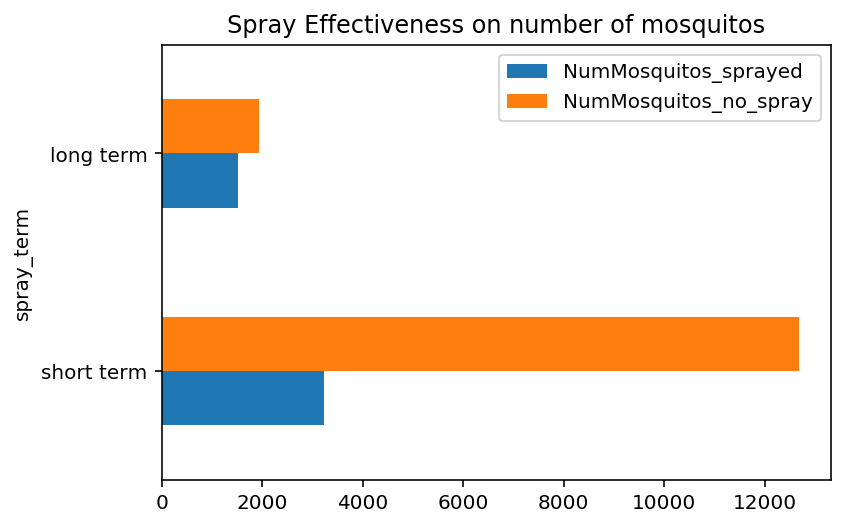

In [176]:
group[['NumMosquitos_sprayed','NumMosquitos_no_spray']].plot(kind='barh', title='Spray Effectiveness on number of mosquitos')

In [157]:
f = {'sprayed':'count', 'WnvPresent':'sum', 'NumMosquitos_sum':'sum', 'NumMosquitos_sum_ns':'sum'}
group = spray_exp.groupby(['Species','spray_term']).agg(f)
group.rename(columns={'sprayed':'Observation', 'NumMosquitos_sum':'NumMosquitos_sprayed', 
                     'NumMosquitos_sum_ns':'NumMosquitos_no_spray'},inplace=True)
group = group.reindex(index = ['short term', 'long term'],level=1)
group['NumMosquitos_sprayed'] = group['NumMosquitos_sprayed'].round(0).astype(int)
group['NumMosquitos_no_spray'] = group['NumMosquitos_no_spray'].round(0).astype(int)
group['Spray_effectiveness'] = ((group['NumMosquitos_sprayed']-group['NumMosquitos_no_spray'])/
                                                 group['NumMosquitos_no_spray']).map(lambda x: "{0:.2f}%".format(x * 100))
group

Observation  WnvPresent  \
Species                spray_term                            
CULEX PIPIENS          short term           60           6   
                       long term            12           3   
CULEX PIPIENS/RESTUANS short term           83          11   
                       long term            30           5   
CULEX RESTUANS         short term           34           1   
                       long term            21           0   
CULEX TERRITANS        short term            1           0   

                                   NumMosquitos_sprayed  \
Species                spray_term                         
CULEX PIPIENS          short term                   915   
                       long term                    244   
CULEX PIPIENS/RESTUANS short term                  1888   
                       long term                    809   
CULEX RESTUANS         short term                   427   
                       long term                    469   
CULEX TERRITANS        short term                     1   

                                   NumMosquitos_no_spray Spray_effectiveness  
Species                spray_term                                             
CULEX PIPIENS          short term                   3729             -75.46%  
                       long term                     320             -23.75%  
CULEX PIPIENS/RESTUANS short term                   5704             -66.90%  
                       long term                    1125             -28.09%  
CULEX RESTUANS         short term                   3260             -86.90%  
                       long term                     486              -3.50%  
CULEX TERRITANS        short term                      0                inf%